# Filter down the folded paired states to an orderable subset

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_shifties
running on node: dig27


### Set working directory to the root of the crispy_shifty repo

In [2]:
os.chdir("/projects/crispy_shifty")

### Fix the paths
Necessary because we copied these designs from perlmutter

In [ ]:
from crispy_shifty.utils.io import fix_path_prefixes

folded = os.path.join(
    os.getcwd(),
    "projects/crispy_shifties/08_fold_paired_states_X/folded_paired_states.list",
)
new_folded = fix_path_prefixes(
    find="/pscratch/sd/p/pleung",
    replace="/mnt/projects/crispy_shifty/projects/crispy_shifties",
    file=folded,
    overwrite=True,
)

### Filter the predicted states

In [ ]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "09_filter_and_order"
design_list_file = os.path.join(
    os.getcwd(),
    "projects/crispy_shifties/08_fold_paired_states_X/folded_paired_states.list",
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")
options = " ".join(
    [
        "out:level 200",
        "corrections:beta_nov16 true",
        "indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    ]
)

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.msd.filter_paired_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="4G",
    nstruct=1,
    nstruct_per_task=1,
    options=options,
    simulation_name=simulation_name,
)

### Collect scorefiles of the filtered states and concatenate

In [3]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "09_filter_and_order"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Load resulting concatenated scorefile

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

### Dump scores_df as a CSV and then reload, for performance reasons

In [5]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [6]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [7]:
rosetta = scores_df[scores_df["designed_by"] == "rosetta"]
mpnn = scores_df[scores_df["designed_by"] == "mpnn"].sample(1000, random_state=0)
sample_df = pd.concat([rosetta, mpnn])

### Remove score terms we don't care about

In [8]:
from crispy_shifty.protocols.design import beta_nov16_terms

sample_df = sample_df[
    [term for term in sample_df.columns if term not in beta_nov16_terms]
]
print(len(sample_df))
print(list(sample_df.columns))

1031
['A_final_seq', 'A_sap', 'A_score_per_res', 'A_total_score', 'A_wnm_all', 'A_wnm_helix', 'B_final_seq', 'B_sap', 'B_score_per_res', 'B_total_score', 'B_wnm_all', 'B_wnm_helix', 'C_final_seq', 'C_sap', 'C_score_per_res', 'C_total_score', 'C_wnm_all', 'C_wnm_helix', 'Y_cms', 'Y_ddg', 'Y_mean_pae', 'Y_mean_pae_interaction', 'Y_mean_pae_interaction_AB', 'Y_mean_pae_interaction_BA', 'Y_mean_pae_intra_chain', 'Y_mean_pae_intra_chain_A', 'Y_mean_pae_intra_chain_B', 'Y_mean_plddt', 'Y_model', 'Y_pTMscore', 'Y_recycles', 'Y_rmsd_to_reference', 'Y_sap', 'Y_score_per_res', 'Y_seed', 'Y_tol', 'Y_total_score', 'Y_type', 'bb_clash', 'bb_clash_delta', 'bb_clash_delta_x', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'interface', 'loop_dist'

In [9]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

### Plot Y Rosetta metrics

16it [00:01, 11.57it/s]


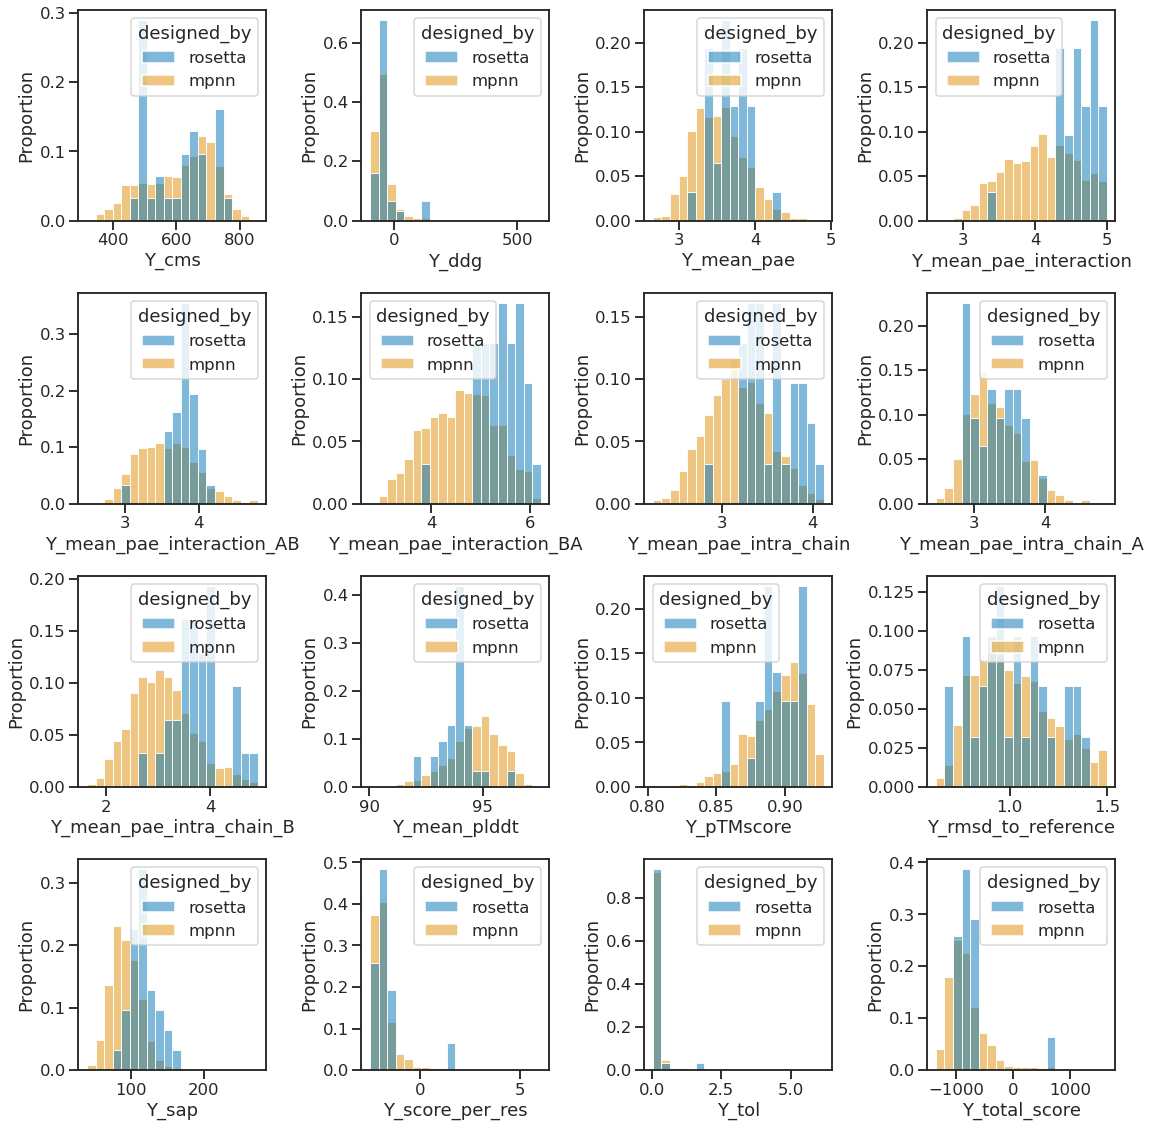

In [10]:
avoid = ["Y_model", "Y_recycles", "Y_seed", "Y_type"]
cols = [col for col in scores_df.columns if "Y_" in col and col not in avoid]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "Y_all_scores.png"))

5it [00:00, 13.46it/s]


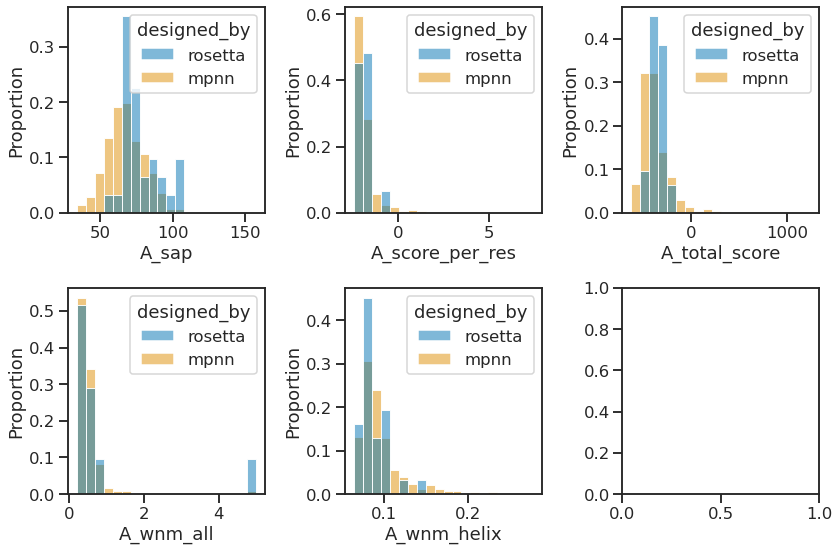

In [11]:
cols = [col for col in scores_df.columns if "A_" in col and "final_seq" not in col]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "A_all_scores.png"))

5it [00:00, 13.24it/s]


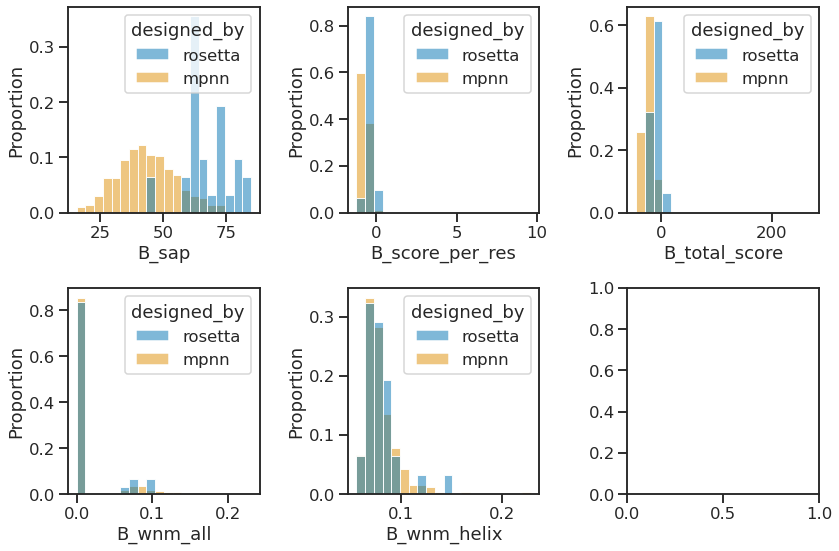

In [12]:
cols = [col for col in scores_df.columns if "B_" in col and "final_seq" not in col]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "B_all_scores.png"))

5it [00:00, 14.07it/s]


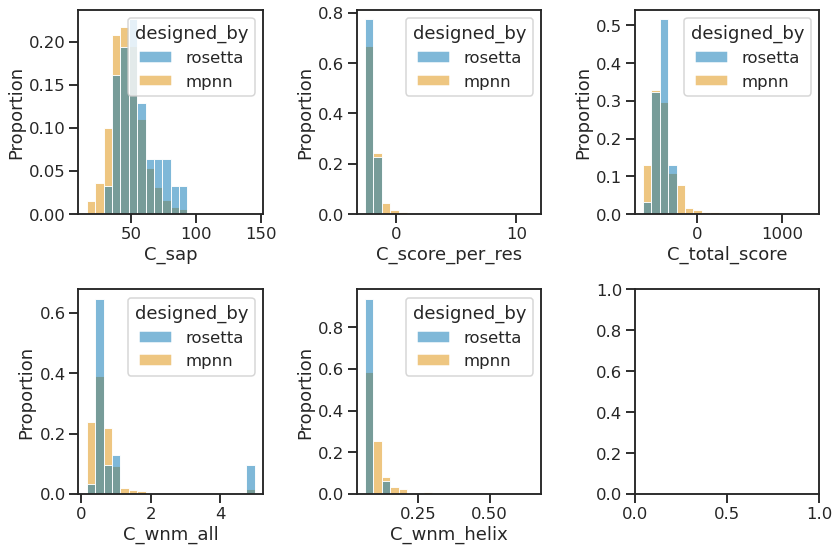

In [13]:
cols = [col for col in scores_df.columns if "C_" in col and "final_seq" not in col]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "C_all_scores.png"))

7it [00:00, 13.39it/s]


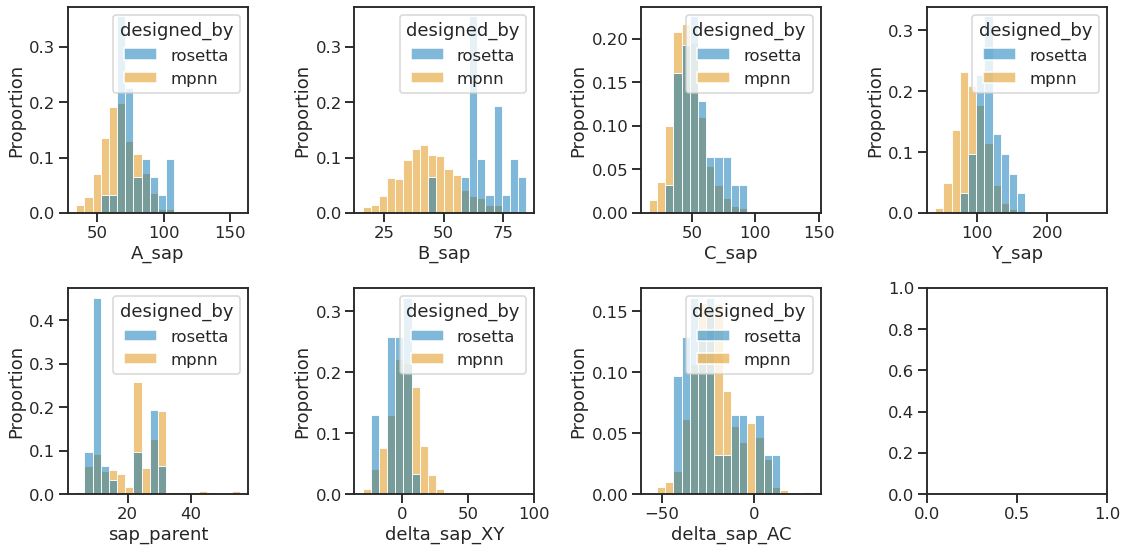

In [14]:
sample_df["delta_sap_XY"] = sample_df["Y_sap"] - (
    sample_df["C_sap"] + sample_df["B_sap"]
)
sample_df["delta_sap_AC"] = sample_df["C_sap"] - sample_df["A_sap"]


cols = [col for col in scores_df.columns if "sap" in col] + [
    "delta_sap_XY",
    "delta_sap_AC",
]


the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "sap_all_scores.png"))

<Figure size 2016x2016 with 0 Axes>

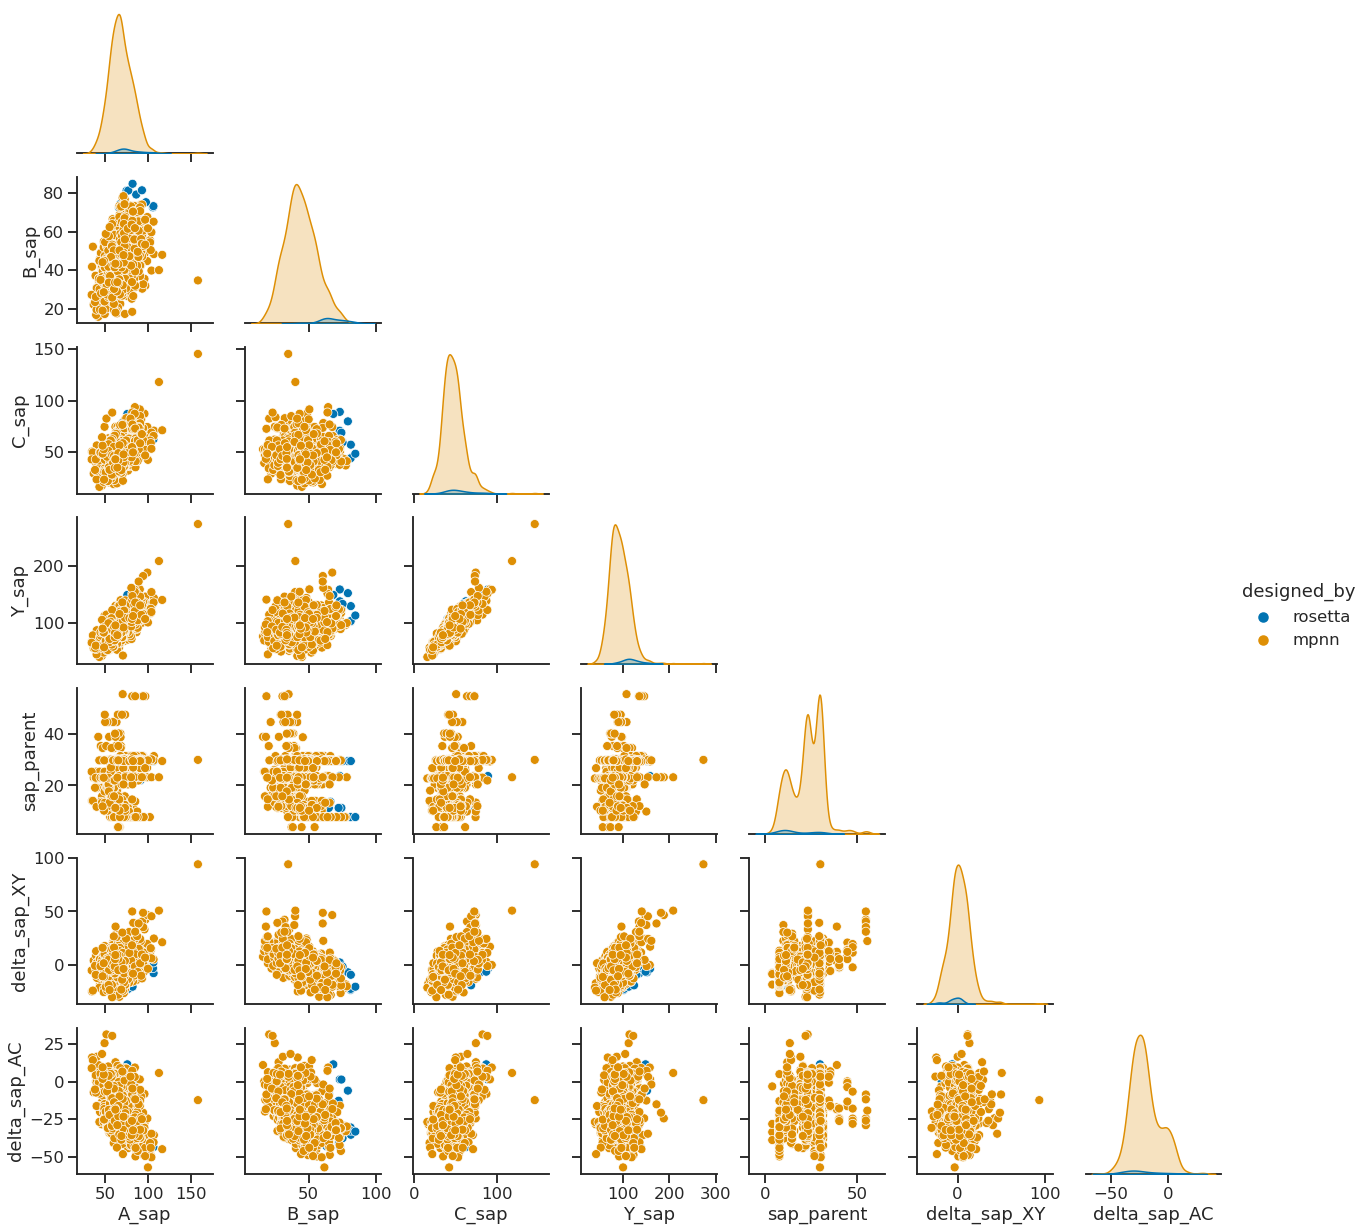

In [15]:
the_fig = pairplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
)
plt.savefig(os.path.join(output_path, "sap_all_scores_paired.png"))

12it [00:00, 12.99it/s]


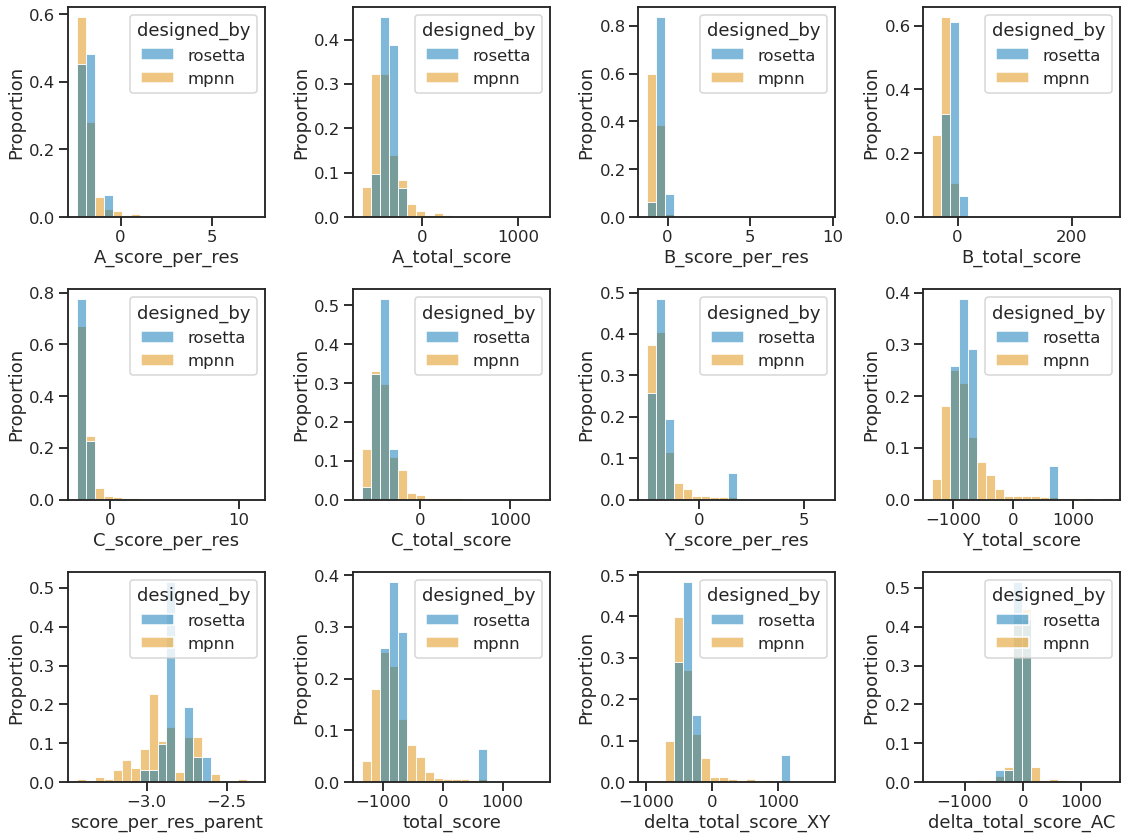

In [16]:
sample_df["delta_total_score_XY"] = sample_df["Y_total_score"] - (
    sample_df["C_total_score"] + sample_df["B_total_score"]
)
sample_df["delta_total_score_AC"] = (
    sample_df["C_total_score"] - sample_df["A_total_score"]
)
avoid = ["Y_pTMscore", "pTMscore", "score", "score_per_res", "score_per_res_x"]
cols = [col for col in scores_df.columns if "score" in col and col not in avoid] + [
    "delta_total_score_XY",
    "delta_total_score_AC",
]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "rosetta_all_scores.png"))

11it [00:01,  9.19it/s]


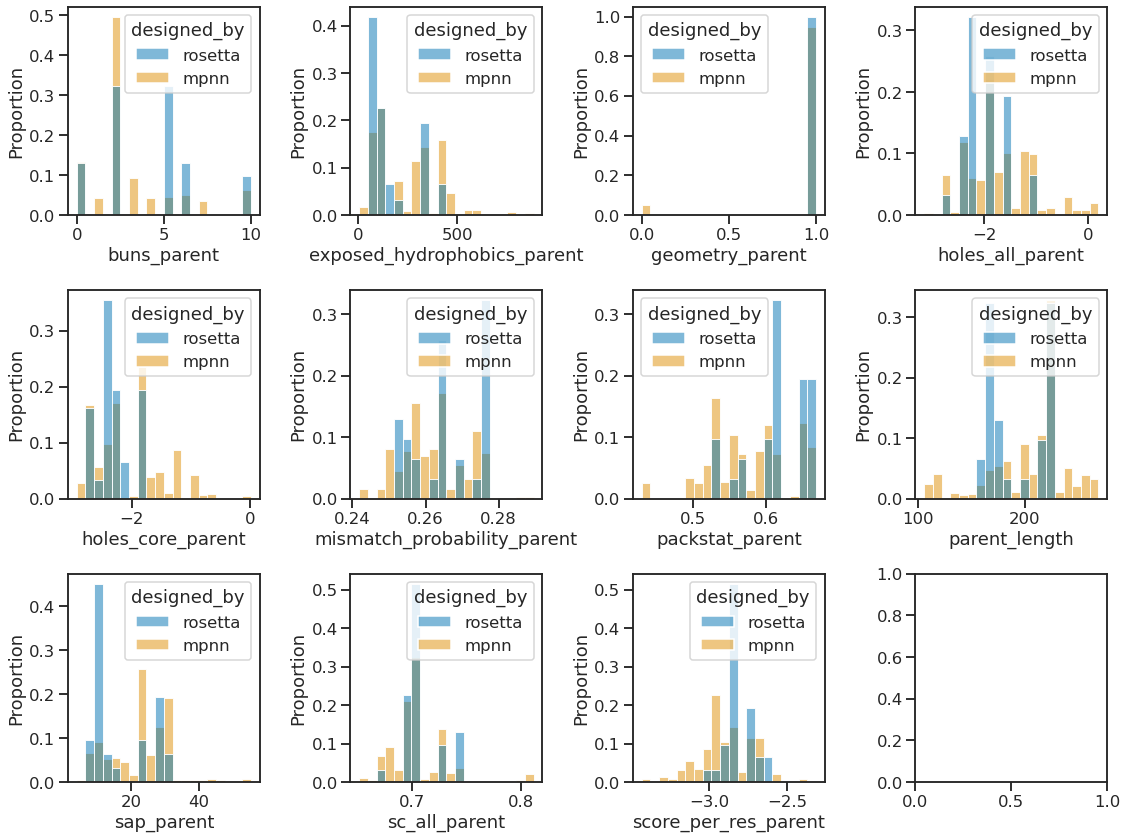

In [17]:
cols = [col for col in scores_df.columns if "parent_" in col or "_parent" in col]

the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    hue="designed_by",
    stat="proportion",
    common_norm=False,
    bins=20,
)
plt.savefig(os.path.join(output_path, "parent_all_scores.png"))

### Filter the whole df

In [18]:
scores_df["delta_sap_XY"] = scores_df["Y_sap"] - (
    scores_df["C_sap"] + scores_df["B_sap"]
)
scores_df["delta_sap_AC"] = scores_df["C_sap"] - scores_df["A_sap"]

scores_df["delta_total_score_XY"] = scores_df["Y_total_score"] - (
    scores_df["C_total_score"] + scores_df["B_total_score"]
)
scores_df["delta_total_score_AC"] = (
    scores_df["C_total_score"] - scores_df["A_total_score"]
)
query = " ".join(
    [
        "delta_total_score_XY < 0",
        "and delta_total_score_AC < 0",
        "and delta_sap_XY < 0",
        "and delta_sap_AC < 0",
        "and B_sap < 50",
        "and C_sap < 50",
        "and Y_sap < 80",
    ]
)

filtered = scores_df.query(query)
len(filtered)

679

In [19]:
print(list(sorted(set([v for v in filtered.state.values if len(v) == 17]))))

['DHR20_p_4_s_3_d_3', 'DHR26_p_4_s_3_d_5', 'DHR27_p_4_s_3_d_3', 'DHR54_p_5_s_3_d_6', 'DHR80_p_5_s_3_d_4', 'DHR81_p_5_s_3_d_4', 'DHR81_p_5_s_3_d_6', 'DHR82_p_5_s_3_d_4']


### Get a set of 24 by getting at least one of each state and maxing some metrics

In [20]:
to_order = []

for state in sorted(list(set(filtered.state.values))):
    if len(state) != 17:
        continue
    else:
        subset_df = filtered.query(f"state == @state")
        # if len is less than or equal to 3 take all,
        if len(subset_df) <= 3:
            to_order.extend(list(subset_df.index))
        # else, take min sap_C, min delta_sap_XY, and min delta_total_score_XY
        else:
            subset_df.sort_values(
                "C_sap", axis=0, ascending=True, ignore_index=False, inplace=True
            )
            to_order.append(list(subset_df.index)[0])
            subset_df.sort_values(
                "delta_sap_XY", axis=0, ascending=True, ignore_index=False, inplace=True
            )
            # check to see if it was already added
            for i in range(len(subset_df)):
                if list(subset_df.index)[i] not in to_order:
                    to_order.append(list(subset_df.index)[i])
                    break
                else:
                    continue
            subset_df.sort_values(
                "delta_total_score_XY",
                axis=0,
                ascending=True,
                ignore_index=False,
                inplace=True,
            )
            # check to see if it was already added
            for i in range(len(subset_df)):
                if list(subset_df.index)[i] not in to_order:
                    to_order.append(list(subset_df.index)[i])
                    break
                else:
                    continue
# add 3 random ones to get to 24
random_dhr_df = filtered.query("scaffold_type == 'tj_DHRs_final'").sample(
    3, random_state=0
)
to_order.extend(list(random_dhr_df.index))

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [21]:
print(len(to_order))
print(len(set(to_order)))

24
24


In [22]:
to_order_df = scores_df.loc[to_order]

In [23]:
# to_order_df.delta_total_score_XY.values
to_order_df.columns

Index(['A_final_seq', 'A_sap', 'A_score_per_res', 'A_total_score', 'A_wnm_all',
       'A_wnm_helix', 'B_final_seq', 'B_sap', 'B_score_per_res',
       'B_total_score',
       ...
       'total_length', 'total_score', 'trimmed_length', 'type', 'wnm_all_x',
       'yhh_planarity', 'delta_sap_XY', 'delta_sap_AC', 'delta_total_score_XY',
       'delta_total_score_AC'],
      dtype='object', length=147)

In [24]:
def seq2chargeA(row: pd.Series, chain: str) -> float:
    from Bio.SeqUtils.ProtParam import ProteinAnalysis

    seq = row[f"{chain}_final_seq"]
    analysis = ProteinAnalysis(seq)
    return analysis.charge_at_pH(7)


to_order_df["A_charge"] = to_order_df.progress_apply(seq2chargeA, chain="A", axis=1)
to_order_df["B_charge"] = to_order_df.progress_apply(seq2chargeA, chain="B", axis=1)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

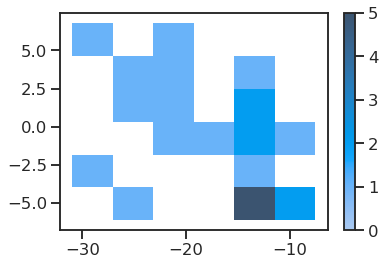

In [25]:
the_fig = sns.histplot(
    x=to_order_df.A_charge.values, y=to_order_df.B_charge.values, cbar=True
)

### Save a list of outputs

In [26]:
simulation_name = "09_filter_and_order"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")

with open(os.path.join(output_path, "filtered_orderable.list"), "w") as f:
    for path in tqdm(to_order):
        print(path, file=f)

  0%|          | 0/24 [00:00<?, ?it/s]

### Make an order with `domesticator`
TODO do this better in production

In [27]:
def cmd_no_stderr(command, wait=True):
    """@nrbennet @bcov @pleung"""

    import subprocess

    the_command = subprocess.Popen(
        command,
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        universal_newlines=True,
    )
    if not wait:
        return
    the_stuff = the_command.communicate()
    return str(the_stuff[0])


def capture_1shot_domesticator(stdout: str) -> str:
    """split input into lines.
    loop once through discarding lines up to ones including >.
    return joined output"""
    sequence = []
    append = False
    for line in stdout.splitlines():
        if append:
            sequence.append(line)
        else:
            pass
        if ">unknown_seq1" in line:
            append = True
        else:
            pass
    to_return = "".join(sequence)
    return to_return

### Reindex `to_order_df` and make sure it is set to the same order as the ordered sequences
previously had an issue where the order got mixed up due to the non-deterministic `set()` method in python

In [28]:
order = []
with open(os.path.join(output_path, "filtered_orderable.list"), "r") as f:
    for line in f:
        order.append(line.rstrip())
to_order_df = to_order_df.reindex(order)
ids = [f"cs_{i}" for i in range(200, 224)]
to_order_df["id"] = ids
to_order_df.head()

,A_final_seq,A_sap,A_score_per_res,A_total_score,A_wnm_all,A_wnm_helix,B_final_seq,B_sap,B_score_per_res,B_total_score,...,type,wnm_all_x,yhh_planarity,delta_sap_XY,delta_sap_AC,delta_total_score_XY,delta_total_score_AC,A_charge,B_charge,id
/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0002/09_filter_and_order_1e3b2aab29414c85acd4b5738d4ba4b1.pdb.bz2,EMKEEIRRLAEELEKKTKDEEVKELARKAAELAEKSDNEEVLEVVK...,38.379292,-1.865501,-287.287109,0.357096,0.084025,EERKKKLAREVVREARRLIERLAEEE,24.307537,-0.804908,-20.927603,...,monomer_ptm,0.811603,0.0,-5.638378,-20.378883,-349.884287,-23.304626,-14.054658,0.858681,cs_200
/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0002/09_filter_and_order_81621ef5e5204b6ca56877a661b9bf63.pdb.bz2,SMKEEIRKLAEELEKKSTDEEVKRLAREAAELAEKSKDERVLEVVK...,43.825504,-0.050750,-7.815495,1.119960,0.074414,MEEREELARKVIELAEEIIKELAEKE,32.887589,-0.802612,-20.867918,...,monomer_ptm,0.659009,0.0,-5.501322,-18.554800,-65.121935,-118.101390,-8.376190,-5.469320,cs_201
/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0002/09_filter_and_order_e23a3da1b3684c928342ae2159d29b6e.pdb.bz2,MMREEIERLARELRERTEDEEVRRLAEEAAELARESEDEEVLEIVK...,50.739410,-2.004133,-308.636505,0.615830,0.075987,EEEKEELRKEIIERAKKLIERLAKEA,27.463758,-1.210908,-31.483608,...,monomer_ptm,0.665467,0.0,-5.037582,-22.364496,-362.372288,-31.956879,-18.386227,-1.145714,cs_202
/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0003/09_filter_and_order_8f66e3c2aa414e35add1c6572b7f3609.pdb.bz2,DKEERLRQQVEKAEKKLEKLAKQSTDEEVRQIAREVAKQLRRLAEL...,61.017479,-1.878329,-392.570709,0.457711,0.088850,MEEKVEKIKELVKEMVELAIKWAEEKIKELEES,42.494061,-1.051593,-34.702560,...,monomer_ptm,0.710969,0.0,-6.627865,-22.018204,-451.793076,-13.326172,-13.125919,-4.475723,cs_203
/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0002/09_filter_and_order_e843aaa59cf14fadbbf752bb07a548b0.pdb.bz2,TRQKEQLDEVLEEIQRLAEEARKRETDEERAKKIQEEAEKAKELLR...,57.303333,-1.938689,-418.756714,0.460491,0.088282,SEEKEERVLERLLRVSRLIAEAVKRAMEMLVEAS,48.960304,-0.762050,-25.909695,...,monomer_ptm,0.625269,0.0,-12.231697,-30.262318,-482.006809,-3.022339,-22.440404,-1.519418,cs_204


### Reverse translate

In [ ]:
prefix = "atactacggtctcaagga"  # for scarless cloning
suffix = "GGttcccgagaccgtaatgc"  # for scarless cloning
long_prefix = "TTTAGCGCGCCGCCTGACGGATGATGCGCGAAGAAATTGAACGCCTGGCGCGCGAATTCGTGAACGTACCGAAGATGAAGAGGTGCGCCGACatactacggtctcaagga"
long_suffix = "GGttcccgagaccgtaatgcAAATGAAAGAGGAAATTCGCCGCCTGGCGGAAGAACTGGAAAAGAAAACGAAAGATGAAGAGGTTAAAGAATTAGCCCGCAAAGCGGAAAGA"
with open(os.path.join(output_path, "cs_dna.list"), "w+") as f:
    for chain in tqdm(["A_final_seq", "B_final_seq"]):
        for index, row in tqdm(to_order_df.iterrows()):
            protein = row[chain]
            id_ = row["id"]
            full_id = id_ + chain[0]
            fully_domesticated = capture_1shot_domesticator(
                cmd_no_stderr(
                    f"./scripts/domesticator.py {protein} --avoid_restriction_sites BsaI XhoI NdeI --avoid_patterns AGGAGG GCTGGTGG ATCTGTT GGRGGT --avoid_kmers 8 --avoid_kmers_boost 10 --species e_coli"
                )
            )
            if "A" in chain:
                f.write(full_id + "\t" + prefix + fully_domesticated + suffix + "\n")
            else:
                f.write(
                    full_id
                    + "\t"
                    + long_prefix
                    + fully_domesticated
                    + long_suffix
                    + "\n"
                )

### Dump PDBs and resurface peptides
only resurface the best ones

In [30]:
import shutil
import pyrosetta
from crispy_shifty.protocols.cleaning import (
    path_to_pose_or_ppose,
    trim_and_resurface_peptide,
)

pyrosetta.init("-corrections::beta_nov16 true -out::level 200")

simulation_name = "09_filter_and_order"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")
pdbs_path = os.path.join(output_path, "pdbs")
os.makedirs(pdbs_path, exist_ok=True)

new_chBs = {}

for i, r in tqdm(to_order_df.iterrows(), total=to_order_df.shape[0]):
    pose = next(
        path_to_pose_or_ppose(path=r.name, cluster_scores=True, pack_result=False)
    )
    pose.dump_pdb(os.path.join(pdbs_path, f"{r.id}.pdb"))
    resurf_1 = trim_and_resurface_peptide(pose.clone())
    resurf_1.dump_pdb(os.path.join(pdbs_path, f"{r.id}r1.pdb"))
    new_chBs[r.id] = resurf_1.scores["B_final_seq"]

PyRosetta-4 2021 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2021.50+release.4ff291ed8257ec2d0cd4d96ae4289e1d39ce1007 2021-12-16T00:25:15] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


  0%|          | 0/24 [00:00<?, ?it/s]

### Add resurfaced peptide sequences to df

In [31]:
def add_resurfaced_chB_to_df(row: pd.Series) -> str:
    seq = new_chBs[row.id]
    return seq


to_order_df["B_final_seq_r1"] = to_order_df.progress_apply(
    add_resurfaced_chB_to_df, axis=1
)

  0%|          | 0/24 [00:00<?, ?it/s]

### Reorder the new chBs

In [32]:
from crispy_shifty.utils.ordering import tag_256

n_term_pad, c_term_pad = tag_256[:128], tag_256[128:]
prefix = "atactacggtctcaagga"  # for scarless cloning
suffix = "GGttcccgagaccgtaatgc"  # for scarless cloning
long_prefix = n_term_pad + prefix
long_suffix = suffix + c_term_pad
with open(os.path.join(output_path, "cs_dna_resurf.list"), "w+") as f:
    for index, row in tqdm(to_order_df.iterrows(), total=to_order_df.shape[0]):
        protein = row["B_final_seq_r1"]
        id_ = row["id"]
        full_id = id_ + "Br1"
        fully_domesticated = capture_1shot_domesticator(
            cmd_no_stderr(
                f"./scripts/domesticator.py SGGS{protein}SGGS \
                --avoid_restriction_sites BsaI XhoI NdeI \
                --avoid_patterns AGGAGG GCTGGTGG ATCTGTT GGRGGT \
                --avoid_kmers 8 --avoid_kmers_boost 10 --species e_coli"
            )
        )
        f.write(full_id + "\t" + long_prefix + fully_domesticated + long_suffix + "\n")

  0%|          | 0/24 [00:00<?, ?it/s]

### Dump the `to_order_df` as a final CSV

In [33]:
if not os.path.exists(os.path.join(output_path, "final_order_scores.csv")):
    to_order_df.to_csv(
        os.path.join(output_path, "final_order_scores.csv"), index_label="pdb_path"
    )

### Dump PDBs and resurface peptides
only resurface the best ones

In [29]:
import shutil
import pyrosetta
from crispy_shifty.protocols.cleaning import (
    path_to_pose_or_ppose,
    trim_and_resurface_peptide,
)

pyrosetta.init("-corrections::beta_nov16 true -out::level 200")

simulation_name = "09_filter_and_order"
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifties/{simulation_name}")
pdbs_path = os.path.join(output_path, "pdbs")
os.makedirs(pdbs_path, exist_ok=True)

new_chBs = {}

for i, r in tqdm(to_order_df.iterrows(), total=to_order_df.shape[0]):
    pose = next(
        path_to_pose_or_ppose(path=r.name, cluster_scores=True, pack_result=False)
    )
    resurf_2 = trim_and_resurface_peptide(pose.clone())
    resurf_2.dump_pdb(os.path.join(pdbs_path, f"{r.id}r2.pdb"))
    new_chBs[r.id] = resurf_2.scores["B_final_seq"]

PyRosetta-4 2022 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python38.Release 2022.12+release.a4d79705213bc2acd6b51e370eddbb2738df6866 2022-03-20T21:59:37] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


  0%|          | 0/24 [00:00<?, ?it/s]

### Add resurfaced peptide sequences to df

In [30]:
def add_resurfaced_chB_to_df(row: pd.Series) -> str:
    seq = new_chBs[row.id]
    return seq


to_order_df["B_final_seq_r2"] = to_order_df.progress_apply(
    add_resurfaced_chB_to_df, axis=1
)

  0%|          | 0/24 [00:00<?, ?it/s]

### Reorder the new chBs with `JohnBercow.py`

In [41]:
br2_df = pd.DataFrame(to_order_df[["B_final_seq_r2", "id"]])
order_fasta = os.path.join(output_path, "20220413_order.fasta")
if not os.path.exists(order_fasta):
    with open(order_fasta, "w") as f:
        for index, row in tqdm(br2_df.iterrows(), total=br2_df.shape[0]):
            protein = "SGGS" + row["B_final_seq_r2"] + "SGGS"
            id_ = row["id"]
            full_id = id_ + "Br2"
            print(f">{full_id}", file=f)
            print(protein, file=f)

  0%|          | 0/24 [00:00<?, ?it/s]

### Dump the `to_order_df` as a final CSV

In [42]:
if not os.path.exists(os.path.join(output_path, "final_order_Br2_scores.csv")):
    to_order_df.to_csv(
        os.path.join(output_path, "final_order_scores.csv"), index_label="pdb_path"
    )

### Prototyping blocks

test `filter_paired_state`

In [ ]:
# %%time 
# import pyrosetta

# pyrosetta.init(
    # "-corrections::beta_nov16 -indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5"
# )


# sys.path.insert(0, "/projects/crispy_shifty/")
# from crispy_shifty.protocols.msd import filter_paired_state

# t = filter_paired_state(
#         None,
#         **{
#             'pdb_path': '/mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_760c687ae53646b59bd36bbe91998593.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_2118b14f45e849ac99034c2e36a8230f.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_806db75a0f8949119a54d50ee8c28576.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_bf4fc1710acb4037917254ce283a7223.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1984895bd0d744e7b7c82446e07b8189.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_ff38fa4457a84da1b0d95850f99b6f10.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_c712e867dda84adab431812f7d1ed004.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5b83ffb2312944f084a5557ed82ed5d9.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_b319b9e9da43467596e807f54262cde2.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_fecc3fb836b24903af7b13df546ea87c.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1d931fe681f0482098275e4fd0749d3e.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_e942561def5b4e4491b3c9d9b2d15f76.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_b4791741764a4a1eb28a624286d32a12.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_261a0384260a4d169bab95c703574b15.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5ff0e503a5704aa39ed3b721793432e5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_ea30c907f4d54a0a807e2b3475004032.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_a62763836a9a4543858b45840ede8c70.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d2efc01301a74800b6f5669dba46434b.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_b60157d157614d5eb8d540ec1cad6cbd.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d66fa964e5d545feaa20bd131bb372d5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_c3e8d46a19c3441fb1c02e6ab8cc0f1e.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_f763ddc8862f4716ab73613645b818b5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_b5c33cfd51c74dfa8259136db8fc02e9.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_00e8a2bb6e3241a78f3688a5727f53ca.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1e151d604abe47aca2d3b0d2ca8449bd.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_dda3a86db52549d5881ea816b39fe2fa.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_497eff9bccbc466999ac1445d8c72307.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_35a59b20c8a342dab46b094dc085fbbe.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_9e1e91449de0489a95ecd922947c130c.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_45c296059f6a45879dd55ddb1909bdfd.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_9a8528df5cdd405d81a1d825e281a7d8.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_23965c49bce44dc88f1d373832948c11.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_45dce59a18a742b28c5ade3172290005.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_c6f1549c40824fe4a7b71e548ae44237.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_96b04c0f1f834a07a0de2240712e91dd.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_2e6f7255b1344097b82f1ce9d29b9117.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_0c915ad2756c4728ae0e5292ae9aa73e.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_018f599f71d649bda48372a0f63a6337.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_892f31cdce9e4265b491359fc274d050.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_ab90cfa6b99f4df792b36c5afc737631.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_e8d8ae2c9c684a1c927ca22d0cfee18f.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_a2998e9517124945844771da288f5ad0.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_335f541ac8084aaa99ecae31bada0095.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_bd0143a910f14248a19c9c8b4d05a551.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_9bd90f2f947642ec8e45dc9aa29cd095.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_bd53adc3fba34f378958fb65820ff1c5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_7dfa893d4bee4a4a961c70f127e33c13.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d44931e5caf743bab11932b80e2659ff.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_63921631bf6e44d19d5c978877f830f7.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_25f37915e4d74cef85291bc417db4118.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_12f06b9607dc4f19b6bd12e99f4514ec.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_28182b7490bb430eae7ccde30a0d2754.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d9c4a62d284c44258cfa185e6cffddcb.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5b58abbc36184d88b4039d156541ad04.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_90772bccd98e42bc821ffc28da0aa225.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_f4a09a7f494f49fea4c1535328dc615d.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_c8a9c5ba7e9b490ca72b98e86182cc22.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_a06efe01bba64d39992b001faf05be0c.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d313e754e58a4005a3a1ab885ac2efbb.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_6061f155ab794b0b83f6f2e19db15473.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_3f2369ac5c0c471b9e686b782f761244.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_410e3919547f4adcaedcf972769a6950.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_56f46e89edfb4d83a2102e142f7c1f56.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_9f89cb16e6bf4b26b7f55722659e0596.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_26c2d2d3350d47e28ea86a272299987a.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_507d748832f242d79d589557ff8f8c3a.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5ea6d6ffdf7b4d66b4a1d1fd5de60175.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_986cd31fdbfa47e4af3111b964db5e11.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_f78e47f8d1ea4bf59b53425b29726f96.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5c820da32f73451d847e5e6a3abad86d.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_676b0769624245b9a34e6dfa1dee3ef5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_c97be179d46f4ec08a34153b42b68b0c.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_981e6b2cb50f41f8aee5bda9c8a50c71.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_08c4e9c1de034b09a59add4f767fe65a.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_e1815ba370b64285ae5000b3d4b16292.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_70cf0471881146ac93054f9082a17639.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_5d84254a968e481dba4592d3e2b63dc6.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1b757e1311cc4456a7c510042261493d.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_26f9b1b83be1413c87f681543221cac9.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_f76a614bd449489182e987ecb13a9ce0.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_7f3c8d9f96ba4ec68596a11422725cdd.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_a6429f90372e4cc8a85b415188914a55.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_403c1f10d975414e890a0b9b280eaf0a.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_a582f049287b4b598403c0fd82d217b2.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1d427ef8b2cf43959c61847fef0c9e89.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_10a2d6c9762f4a54ba7c21aecae4b270.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_586163d0e4134e5dbe52efab1a0d67c3.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_4a79bf27aad4406a87f99b23dcbddce7.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_3861ea9bae014dc88c63763f909f0a54.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_8272675c92b84570a0386ad84498991b.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_68c8c93fc0444e4ca2e1fbf1151d944b.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_646b1f3e41244da5ae625cc8c7668de4.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d086fd3d9e2c490faf45e8c60ff3fb93.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_e7f52917fe494a20a32d89860fd906b6.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_f9fd36225b9441fa92107490d388efb5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_1da1cf24ec7a4e6ca139ab3dba7752c5.pdb.bz2 /mnt/home/pleung/projects/crispy_shifty/projects/crispy_shifties/07_fold_paired_states_Y/decoys/0000/07_fold_paired_states_Y_d34ed61477704b7eb443640b82c1cc3c.pdb.bz2',
#         }
# )
# for i, tppose in enumerate(t):
#     tppose.pose.dump_pdb(f"{i}.pdb")

In [ ]:
# tppose.pose.scores

test `trim_and_resurface_peptide`

In [ ]:
%%time 
import pyrosetta

pyrosetta.init(
    "-corrections::beta_nov16"
)


sys.path.insert(0, "/projects/crispy_shifty/")
from crispy_shifty.protocols.cleaning import finalize_peptide

t = finalize_peptide(
        None,
        **{
            'pdb_path': '/mnt/projects/crispy_shifty/projects/crispy_shifties/09_filter_and_order/decoys/0006/09_filter_and_order_e9b844167bf84dd2ac7cde5045dc43b1.pdb.bz2',
        }
)
for i, tppose in enumerate(t):
    tppose.pose.dump_pdb(f"{i}.pdb")

In [ ]:
# tppose.pose.scores